# CatBoost Model with Clustered Features

## Importing Libraries & Data

In [1]:
import numpy as np 
import pandas as pd 
import geopandas as gpd

import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor, Pool

import shap
from yellowbrick.regressor import PredictionError

import warnings
warnings.filterwarnings("ignore", category = RuntimeWarning)

c:\Users\hussa\OneDrive\Desktop\Projects\adrians_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading CSV
listings = pd.read_csv("clustered_listings.csv", encoding='latin-1')

In [3]:
# Checking missing values
listings.isna().sum()[listings.isna().sum() != 0]

bathrooms               72
bedrooms               673
beds                  1037
has_avail             2516
has_pfp                 46
id_ver                  46
is_superhost          4070
lst_cnt                 46
nbhd                 49301
rsp_time             39466
total_lst_cnt           46
rev_acc              72891
rev_checkin          72891
rev_clean            72891
rev_coms             72891
rev_loc              72900
rev_rating           72872
rev_val              72891
reviews_per_month    72872
tenure                  46
host_since_year         46
host_since_month        46
dtype: int64

## Imputing data

In [4]:
# Loading GeoJSON to map neighborhoods onto with lat/lon
nbhd_gdf = gpd.read_file("custom_neighborhoods_nyc.geojson")
nbhd_gdf.columns

# Resetting index before creating gpd df
listings = listings.reset_index(drop = False) 

# Dropping old columns
listings = listings.drop(columns=["nbhd", "boro"])

# Converting listings to gpd df
listings_gdf = gpd.GeoDataFrame(listings, geometry = gpd.points_from_xy(listings.lon, listings.lat), crs = nbhd_gdf.crs)

# Spatial Join
listings_gdf = gpd.sjoin(listings_gdf, nbhd_gdf[["neighborhood", "borough", "geometry"]], how = "left", predicate = "within")

# Renaming columns to match original df column names
listings_gdf = listings_gdf.rename(columns={"neighborhood": "nbhd", "borough": "boro"})

# Mapping new values by joining
listings = listings.merge(listings_gdf[["index", "nbhd", "boro"]], on = "index", how = "left")

# Dropping index
listings_pp = listings.drop(columns = ["index"])

# Filling in points that did not map out
listings["nbhd"] = listings["nbhd"].fillna("Unknown")
listings["boro"] = listings["boro"].fillna("Unknown")

In [5]:
# Replacing -1 with isolated
listings["cluster"] = listings["cluster"].str.replace("-1", "isolated")

## Train-Test Split

In [6]:
# Separating target variable from features
X = listings.drop(columns = ["price"])
y = listings["price"]

In [7]:
# Train-test-split for dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2025)

In [8]:
# # Log transforming target variable for improved stability
# y_train_log = np.log(y_train)
# y_test_log = np.log(y_test)

In [9]:
# Assigning non one-hot encoded categories for CatBoost
cat_features = ["boro", "nbhd", "rsp_time", "cluster"]

In [10]:
# Replacing NaN values with string values for CatBoost
X_train[cat_features] = X_train[cat_features].fillna("Missing")
X_test[cat_features]  = X_test[cat_features].fillna("Missing")

In [11]:
# # Assigning CatBoost Pool objects for training and testing sets (after log scale)
# train_pool = Pool(data = X_train, label = y_train_log, cat_features = cat_features)
# test_pool = Pool(data = X_test, label = y_test_log, cat_features = cat_features)

In [12]:
# Assigning CatBoost Pool objects for training and testing sets
train_pool = Pool(data = X_train, label = y_train, cat_features = cat_features)
test_pool = Pool(data = X_test, label = y_test, cat_features = cat_features)

In [13]:
# # Defining Optuna objective function
# def objective(trial):
#     params = {
#         "iterations": trial.suggest_int("iterations", 400, 1600),
#         "depth": trial.suggest_int("depth", 4, 14),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log = True),
#         "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 2, log = True),
#         "border_count": trial.suggest_int("border_count", 64, 128),
#         "loss_function": "RMSE",
#         "verbose": 0,
#         "thread_count": -1,
#     }
#     # Instantiating CatBoost Model 
#     model = CatBoostRegressor(**params)
#     # Fitting CatBoost
#     model.fit(train_pool, eval_set = test_pool, early_stopping_rounds = 50, verbose = 0)
#     # Model predictions in log space
#     preds_log = model.predict(test_pool)
#     # Converting predictions and y_test back to original scale
#     preds_true = np.exp(preds_log)
#     y_test_true = np.exp(y_test_log)
#     # RMSE for each Trial
#     rmse_true = root_mean_squared_error(y_test_true, preds_true)

#     return rmse_true

In [14]:
# Defining Optuna objective function for MAE
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 400, 1600),
        "depth": trial.suggest_int("depth", 4, 14),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 2, log=True),
        "border_count": trial.suggest_int("border_count", 64, 128),
        "loss_function": "MAE",  # Use MAE as CatBoost loss
        "verbose": 0,
        "thread_count": -1,
        "task_type": "GPU",
    }

    # Instantiating CatBoost Model 
    model = CatBoostRegressor(**params)

    # Fitting CatBoost
    model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50, verbose=0)

    # Model predictions (original scale)
    preds = model.predict(test_pool)

    # MAE for each trial
    mae = mean_absolute_error(y_test, preds)

    return mae


In [15]:
# Creating Optuna study for hyperparameter tuning
study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 20)

[I 2025-10-04 21:57:07,791] A new study created in memory with name: no-name-21c34649-1477-46be-b45f-50bf48f4b47e
Default metric period is 5 because MAE is/are not implemented for GPU
[I 2025-10-04 21:57:20,429] Trial 0 finished with value: 112.53556908162261 and parameters: {'iterations': 749, 'depth': 6, 'learning_rate': 0.014047376573454505, 'l2_leaf_reg': 0.3017105745479271, 'border_count': 79}. Best is trial 0 with value: 112.53556908162261.
Default metric period is 5 because MAE is/are not implemented for GPU
[I 2025-10-04 21:57:25,177] Trial 1 finished with value: 109.3390477997487 and parameters: {'iterations': 446, 'depth': 4, 'learning_rate': 0.06563937147176747, 'l2_leaf_reg': 0.9996534364636177, 'border_count': 104}. Best is trial 1 with value: 109.3390477997487.
Default metric period is 5 because MAE is/are not implemented for GPU
[I 2025-10-04 21:59:21,731] Trial 2 finished with value: 110.23766693826485 and parameters: {'iterations': 492, 'depth': 14, 'learning_rate': 0.

In [16]:
# Getting best parameters of Optuna study and running that model
best_params = study.best_trial.params
best_model = CatBoostRegressor(**best_params, task_type= 'GPU')
best_model.fit(train_pool, eval_set = test_pool, verbose = 0)

In [17]:
# Getting feature importance
feature_importance = best_model.get_feature_importance(prettified = True)
print(feature_importance)

                                     Feature Id  Importances
0                                          nbhd     9.829426
1                                        accomm     8.523282
2                                     bathrooms     7.555813
3                                    min_nights     6.142635
4                                           lon     6.059115
..                                          ...          ...
56                                          nov     0.027684
57  calculated_host_listings_count_shared_rooms     0.025245
58                                          apr     0.010541
59                           prop_vacation_home     0.008849
60                                          oct     0.003352

[61 rows x 2 columns]


## Evaluating Model

In [19]:
# Shap Values
shap_values = best_model.get_feature_importance(train_pool, type = "ShapValues")[:, :-1]

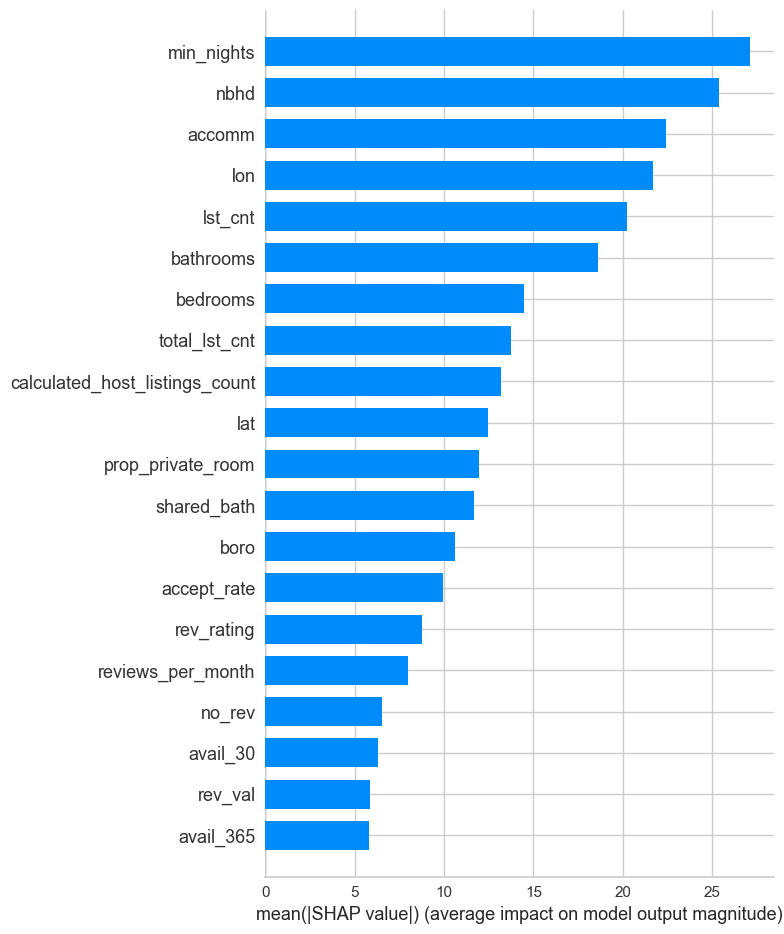

In [20]:
# Shap summary plot for feature importance (top 20 features bar plot)
shap.summary_plot(shap_values, X_train, plot_type = "bar", max_display = 20)

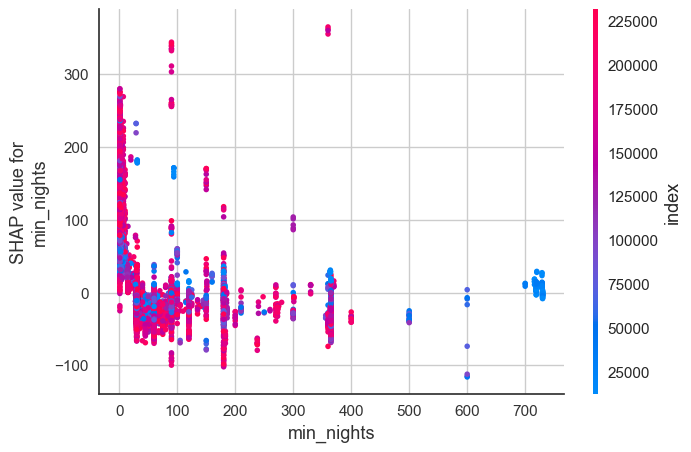

In [24]:
# Shap dependence plot
shap.dependence_plot("min_nights", shap_values, X_train)

In [28]:
# Shap force plot
# shap.force_plot(best_model.predict(X_test)[:100], shap_values[:100], X_test.iloc[:100]) # First 100 predictions force plot

# Shap force plot - Fixed for single output regression
shap.initjs()  # Initialize JavaScript for SHAP plots
explainer = shap.TreeExplainer(best_model)
shap_values_force = explainer.shap_values(X_test.iloc[:100])
# For regression, use the first (and only) output if multi-dimensional
if len(shap_values_force.shape) > 2:
    shap_values_force = shap_values_force[0]
shap.force_plot(explainer.expected_value, shap_values_force, X_test.iloc[:100])

In [ ]:
# Yellowbrick Regression Plot
viz = PredictionError(best_model, task_type= 'GPU')
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

YellowbrickTypeError: This estimator is not a regressor; try a classifier or clustering score visualizer instead!